<a href="https://colab.research.google.com/github/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/blob/main/07_milestone_project_1_food_vision_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision 101

## Check GPU

In [1]:
# !nvidia-smi -L

## Get helper functions

We've created a bunch of helper functions to do small tasks required for our notebooks.

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/refs/heads/main/helper_functions.py

--2025-06-15 15:26:20--  https://raw.githubusercontent.com/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-06-15 15:26:20 (12.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Use TensorFlow Datasets to Download Data

Here is the link of our Food-101 dataset: https://www.tensorflow.org/datasets/catalog/food101

We can also find other Datasets in the same [web home page](https://www.tensorflow.org/datasets/catalog/overview).

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS dataset?

True


In [6]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True) # also returns meta data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.661IIA_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.661IIA_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

To become one with data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # get one of the train data

In [10]:
# What does one sample of our training data look like?
train_one_sample    # samples are in format (image_tensor, label)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 56,
  Class name (str form): huevos_rancheros
  


In [12]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [13]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

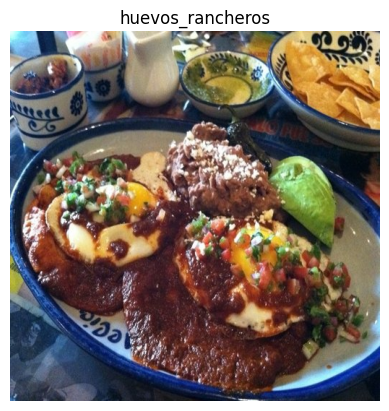

In [14]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

 ## Create preprocessing functions for our data

 Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).
 However, not all data (including data from TensorFlow Datasets) comes like this.
 So, in order to get the data ready for a neural network, we'll often have to write preprocessing functions and map it to our data.


 What we know about our data:
 * In `uint8` datatype
 * Comprised of all different size tensors (different sized images)
 * Not scaled (the pixel values are between 0 & 255)


 What we know `models` like:
 * Data in `float32` dtype (or for mixed precision `float16` and `float32`)
 * For batches, TensorFlow likes all of the tensors within a batch to be of the same size
 * Scaled (values between 0 & 1) also called normalized tensors generally perform better.



 With these points in mind, we've got a few things we can tackle with a preprocessing function.


 Since we're going to be using an `EfficientNetBX` pretrained model from `tf.keras.applications`, we don't need to rescale our data (these architectures have rescaling build-in).

 This means our functions needs to:
 1. Reshape our images to all the same size.
 2. Convert the dtype of our images tensors from `uint8` to `float32`.

In [ ]:
# Make a functions for preprocessing images
